This particular lesson is written in R in the so called [R-markdown format](https://r4ds.had.co.nz/r-markdown.html). It is assumed that you have R and Rstudio installed. In this case you will be able to follow all steps by running the code in the grey boxes beneath. For further information on getting R and Rstudio see the [Prerequisites-section](https://r4ds.had.co.nz/introduction.html#prerequisites) of the book *R for Data Science*. 


This lesson is the first concrete example of how to interact with a specific API and we pick up exactly where we left in the previous lesson [What is an API?](https://github.com/maxodsbjerg/CHCAA_API_lesson/blob/main/what_is_an_API/what_is_an_API.md). The last thing we did in that lesson was to ask the Royal Danish Library's Newspaper API to tell us how many articles mentions "internet". The answer was returned in the JSON-format, which we will save for later, since the Newspaper API can also return answers in CSV-format, which will be the case of this example. CSV is short for Comma Separated Values and is a way of storing data in a raw text format. CSV-files are easily handled by most programming languages and especially R. The main focus of this lesson will therefore be on constructing an request URL to the Newspaper API as explained in the previous chapter. 


As a general rule of thumb it is always best to examine and understand the data that you're trying to extract and the service which stores them and how they make them available before you dive into the API. This process will be total dependent on the specific case and in our case with the Newspaper API it involves diving into what this collection contains. In the following section we will dive into a very short survey of the Danish Newspaper Collection's history to fully understand the . 

The collections exist because legal deposit of published material has been required by law in Denmark since 1697. In the light of this Danish Newspapers has been collected and stored for the future. This led to a lot of physical paper and the library began to photograph the individual pages of each newspaper and store it on microfilm instead. Then from 2014-2017 these microfilms were digitized. This involved a computer running a segmentation algorithm, which runs through all these now digital pages and identifying which headers belonged to which paragraphs thus forming articles. Along with this the computer also recognized the text thus making it searchable. The process of recognizing the text is called [Optical Character Recognition(OCR)](https://en.wikipedia.org/wiki/Optical_character_recognition). These processes were not precise and especially not on the older newspapers, which cause a lot of "misreading" in the OCR-text and in the segmentation of articles. The result is an [ALTO-file](https://en.wikipedia.org/wiki/ALTO_(XML)), which is short for Analyzed Layout and Text Object. This is highly structured data format which stores information on where the individual OCR-recognised words are placed on the page as well as which article they belong to. The best way to imagine an ALTO-file is as a file, that contains the digital layout as recognised by segmentation and OCR.
The combination of the ALTO-file and the digital photograph of the newspaper pages forms a pdf-file that consist of two "layers". One which is the actual picture of the newspaper pages and another layer containing the OCR text making the pdf-file searchable. 

![Visualization of the digitization process of the newspapers - in the segmentation and OCR the colors indicates which text parts has been identified as belonging to each other](pics/digitization_flow.png)
 
The result is of course a lot of pdf-files, but there is also a lot of metadata around these pdf files. For example we have the time of publication, the place of publication and which newspaper it is. 
All this data is presented and made available through an graphical user interface that normal users can interact with. In the case of the newspaper collection this platform is called Mediestream. 

# Advanced searches in Mediestream - a prerequisite for extracting data from the Newspaper API
Let's use the graphical user interface on a specific case. In this case we want to find articles from the correspondent sent out by the newspaper "Dagbladet". These articles should be on internal affairs in France and in Paris and about the politician Charles de Rémusat in the year 1873. The screenshot below shows how the this search is performed in Mediestream. Red circles marks demarcation-elements in the interface that are of particular interest:


![Example search free text search, specification of newspaper, as well as defining time range in the selector tool in the graphical user interface](./pics/mediestream_gui_pac.png)


The top circle is the free text search field. This is where we define that the word "korrespondent", "paris" and "rémusat" must be present in the OCR text of the article that we are looking for. The next circle is where we define the time period of interest. In this case by pointing and clicking through months and years eventually defining from the 1. January 1873 to 31. December 1873 - in other words the entire year of 1873. The last circle is where we have defined that we only have interest in hits in the newspaper "Dagbladet". The results in 9 hits which means that 9 articles(identified as such in the segmentation process) meet our requirements.

This exact search could have been performed entirely from the free text search field using more advanced search codes. Behold this search: 
![Searching with search codes](./pics/mediestream_gui_code.png)


This results in the exact same. 9 hits from the newspaper "Dagbladet". So what has been done differently? Notice the free text search field - here we have appended "py:1873" to our search before. This is an "advanced" search code setting the publication year(py) to 1873. Notice how the time selector is blank - this is because it haven't been used. Furthermore the search code "familyId:dagbladetkoebenhavn1851" has been added, which says that we are only interested in results from the newspaper "Dagsbladet". Since "Dagsbladet" is a fairly popular name for at newspaper(imagine something like "Daily News") we are using a unique id for this particular newspaper. All the newspapers in Mediestream has been given unique ids to avoid ambiguity. Thus we end up with a search string that looks like this: 

> korrespondent AND paris AND rémusat AND py:1873 AND familyId:dagbladetkoebenhavn1851

In order to extract raw data from the newspaper API we need to be able to define the data that we are interested with these kind of advanced search strings. It is a good idea to test the search strings in Mediestream and once you are happy with the amount of hits you take your advanced search string to the API. For more help on constructing search strings see [the page for search advice in Mediestream](https://www2.statsbiblioteket.dk/mediestream/info/soegetips), where you'll also find a link to a list of the aforementioned unique ids for the newspapers.

One important thing to add before venturing on is the limitations in access to the newspaper collection due to copyright. The is because of the newspapers being at the library due to the legal deposit of published material. Thus the some of the material is still under copyright meaning that you can only see newspapers older than 100 years and in order to extract data from the newspaper API the material must be older than 140 years. 

Before venturing on to extracting data from the newspaper API with a search string let's create a string that has more than 9 hits by expanding the time range and removing rémusat, in order to get articles containing paris and korrespondent in the periode 1870 to 1875:

> korrespondent AND paris AND py:[1870 TO 1875] AND familyId:dagbladetkoebenhavn1851

This search gives us 644 hits. Now we have a some what large body of material and we wan't to employ some kind og digital method on them. This can't be done in the graphical user interface of Mediestream. We need to turn our focus to the API connected to Mediestream


# Newspaper API: Converting the search string to a request URL
In order to extract the 644 as raw data in a machine readable format we use the [Swagger](https://swagger.io/docs/specification/2-0/what-is-swagger/) interface for the newspapers API. A Swagger interface is an interactive documentation of an API. This means that you can both try the APIs functionality and get information about which metadata and data is exported. Furthermore the interface shows how you can limit your search. The existence of a Swagger interface (or similiar) is a good sign for data extraction, because it means that the creators have thought about disseminating the APIs functionalities.

Navigating to the [Newspaper API Swagger UI](http://labs.statsbiblioteket.dk/labsapi/api//api-docs?url=/labsapi/api/openapi.yaml) will lead you to the following landing page:
![The landing page of the Newspaper API Swagger UI](pics/swagger_landing.png)
What we see in the blue boxes is all the different services that the API offers - and a text explaining summarizing what these services do. These are called endpoints of the API. In this case we will focus on the first service described in the top blue box, the endpoint: 

> /aviser/export/fields - Export data from old newspapers at http://mediestream.dk/ 

Clicking on this box expands the view and clicking "Try it out" makes the documentation interactive, which is what we want:

![Expanding the /aviser/export/fields endpoint](pics/swagger_try_it_out.png)

The next step is to paste in the search string from before into the query field, which replaces the placeholder search: 
![Pasting in our query](pics/swagger_paste_in_query.png)
Beneath the query field there is a list of all the fields that the API can return. It is a good idea to read through this list as it will give an idea of which kind of analytical questions can be examined through the data. E.g there is a field called "fulltext_org", which contains: **The original OCR text for the article.**. So this tells us that we will be able to perform [text mining](https://en.wikipedia.org/wiki/Text_mining) on our data. Another thing field amongst many is the timestamp which is the publication date for the articles, so adding a temporal perspective in any analysis will also be possible. 
Moving further down the swagger page leads to our next fields og particular focus: 
![Setting max rows and the file format](pics/swagger_max_rows.png)
The first red circle is the "max"-value. This is where you define how many articles you want to have returned by the API. Remember that our current search return 644 articles and the defaul value is 10. By changing this value to "-1" as shown above, we are returned all articles that the search query matches.  
The next step is to change the default format value from JSON to CSV, as shown above! The last step is to press the blue "Activate" button. 

The result is the following: 

![The response in swagger](pics/swagger_response.png)
Here we are given an request url (marked by the red circle). This URL holds a CSV-file that contains our 644 articles. Now that we have this request URL we are ready to import the articles into R. But before we do this we will focus on the Request-URL as given by swagger above


>http://labs.statsbiblioteket.dk/labsapi/api/aviser/export/fields?query=korrespondent%20AND%20paris%20AND%20py%3A%5B1870%20TO%201875%5D%20AND%20familyId%3Adagbladetkoebenhavn1851&fields=link&fields=recordID&fields=timestamp&fields=pwa&fields=cer&fields=fulltext_org&fields=pageUUID&fields=editionUUID&fields=titleUUID&fields=editionId&fields=familyId&fields=newspaper_page&fields=newspaper_edition&fields=lplace&fields=location_name&fields=location_coordinates&max=-1&structure=header&structure=content&format=CSV

In order to bette understand this url we break it into indvidual pieces:  

|Explanation|URL segment
|:------------                 |:-------------
|Base URL                      | http://labs.statsbiblioteket.dk
|API - endpoint                | /labsapi/api/aviser/export/fields
|Query:                        | ?query=korrespondent%20AND%20paris%20AND%20py%3A%5B1870%20TO%201875%5D%20 AND%20familyId%3Adagbladetkoebenhavn1851
|Which fields to export:       |&fields=link&fields=recordID&fields=timestamp&fields=pwa&fields=cer&fields=fulltext_org&fields=pageUUID &fields=editionUUID&fields=titleUUID&fields=editionId&fields=familyId&fields=newspaper_page &fields=newspaper_edition&fields=lplace&fields=location_name&fields=location_coordinates
|Max number of rows to return  |&max=-1
|Structure                     | &structure=header&structure=content|
|File format to return:        | &format=CSV|

So in summary the Swagger interface constructs a fairly complex URL by presenting the options in a user friendly graphical interface. It is this particular request URL that we need in our programming software in ordner to load the data in. In the next section we will load the data into R and do a simple analysis, were we want know the dispersion of articles in our five year period. 



In [19]:
import pandas as pd

import matplotlib as plt

# Loading data from the Newpaper API 
By copying the request URL from the Newspaper API swagger interfaces we can paste into the following function:


In [3]:
dagsbladet_paris = pd.read_csv("http://labs.statsbiblioteket.dk/labsapi/api/aviser/export/fields?query=korrespondent%20AND%20paris%20AND%20py%3A%5B1870%20TO%201875%5D%20AND%20familyId%3Adagbladetkoebenhavn1851&fields=link&fields=recordID&fields=timestamp&fields=pwa&fields=cer&fields=fulltext_org&fields=pageUUID&fields=editionUUID&fields=titleUUID&fields=editionId&fields=familyId&fields=newspaper_page&fields=newspaper_edition&fields=lplace&fields=location_name&fields=location_coordinates&max=-1&structure=header&structure=content&format=CSV")

A brief summary of the current situation is that our data is dilivered in by the request URL in CSV-format, which is short for Comma Separated Values. CSV files are structured in columns separated by commas and in rows separated by lines. Each row in the data correspond to identified articles by the segmentations-process during the digitisation process of the newspapers. The request URL is pasted in the `pd.read_csv()`-functions, which parses the data into a dataframe in Python. This dataframe is named "dagsbladet_paris".  

If we just type in the name of the dataframe, we see a outline of our data:

In [4]:
dagsbladet_paris

,link,recordID,timestamp,pwa,cer,fulltext_org,pageUUID,editionUUID,titleUUID,editionId,familyId,newspaper_page,newspaper_edition,lplace,location_name,location_coordinates
0,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:4fe91a14-9351-4e...,1870-01-12T01:00:00,65.6,0.344,"bladet\nOnsdage« den IS Januar.\nVenner, for a...",doms_aviser_page:uuid:4fe91a14-9351-4e05-8863-...,doms_aviser_edition:uuid:2158770b-efd7-495a-9b...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1870-01-12 001,dagbladetkoebenhavn1851,1,1,København,Frankrig\nFriheden\nHold\nGrund\nHelvede\nBona...,"9.68804668151,56.0925269907\n10.3426132261,56...."
1,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:991f31ec-e696-41...,1870-01-13T01:00:00,55.9,0.441,Dagbladet\nTorsdagen den 13« Januar.\ngivende ...,doms_aviser_page:uuid:991f31ec-e696-4124-a18f-...,doms_aviser_edition:uuid:8592f9e1-3693-4b21-a9...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1870-01-13 001,dagbladetkoebenhavn1851,1,1,København,Frankrig\nGrund\nLykken\nFald\nKammer\nRusland...,"9.68804668151,56.0925269907\n10.3426132261,56...."
2,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:8edf539c-4186-4e...,1870-01-14T01:00:00,64.5,0.355,"1870.\ntil Rochefort, og en as Rcdakteurcrne v...",doms_aviser_page:uuid:8edf539c-4186-4e46-8a0c-...,doms_aviser_edition:uuid:1ecd79d2-9378-4dd2-b0...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1870-01-14 001,dagbladetkoebenhavn1851,1,1,København,Frankrig\nRoligheden\nHammelev\nBerlin\nGlimt\...,"9.68804668151,56.0925269907\n10.3426132261,56...."
3,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:fc9aee91-0946-4b...,1870-01-28T01:00:00,53.6,0.464,for de tilstedeværende Skandinavers Adoptiv fæ...,doms_aviser_page:uuid:fc9aee91-0946-4bdd-bf4b-...,doms_aviser_edition:uuid:be84b070-d241-4277-bb...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1870-01-28 001,dagbladetkoebenhavn1851,3,1,København,Frankrig\nGrund\nBjerge\nBerlin\nMalle\nHage\n...,"9.68804668151,56.0925269907\n10.3426132261,56...."
4,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:15680a18-5e0d-4b...,1870-02-01T01:00:00,60.8,0.392,Dagbladet\nTirsragen »en I. Zrbruar.\nlyst og ...,doms_aviser_page:uuid:15680a18-5e0d-4bf5-b0b5-...,doms_aviser_edition:uuid:2277f06a-52c4-41e5-a6...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1870-02-01 001,dagbladetkoebenhavn1851,1,1,København,Rat\nFrankrig\nKrig\nWashington\nLøbet\nParis\...,"10.7165553117,54.7318893306\n9.68804668151,56...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
639,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:56ed35e0-b632-49...,1875-12-13T01:00:00,49.2,0.508,M.iii«!;iLrth I-t« Hnvrnbrr.\n1 S7\n|V)i).>l' ...,doms_aviser_page:uuid:56ed35e0-b632-4965-bd9c-...,doms_aviser_edition:uuid:424a780e-42f5-433f-86...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1875-12-13 001,dagbladetkoebenhavn1851,1,1,København,Kolding\nTaleren\nGrund\nAabenraa\nTyskland\nV...,"9.48351672776,55.5011822473\n9.48145698254,55...."
640,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:3d19ac4f-70d2-43...,1875-12-15T01:00:00,51.0,0.490,"l.lsll fra \\ rn<l re |,r rnneit I > 1. g. red...",doms_aviser_page:uuid:3d19ac4f-70d2-43db-b71e-...,doms_aviser_edition:uuid:aa6b3c1f-0db6-4b8a-b4...,doms_aviser_title:uuid:d55892ba-d236-4e90-bb83...,dagbladetkoebenhavn1851 1875-12-15 001,dagbladetkoebenhavn1851,2,1,København,Taleren\nAarhus\nLeveret\nStuen\nPetersborg\nI...,"12.5409803237,54.9882939866\n10.1720455217,56...."
641,http://www2.statsbiblioteket.dk/mediestream/av...,doms_newspaperCollection:uuid:775b31dd-50fb-43...,1875-12-22T01:00:00,51.2,0.488,> Udhævet af mig\nset ud. da I »


The next step is to do the relatively simple examination of the timely dispersion of these articles containing "korrespondent" and "paris" in the period 1870 to 1875 from the newspaper Dagsbladet. 

# Timely dispersion of articles in the period 1870 to 1875

Currently the only column we have containing temporal information is the column "timestamp". The information stored in this column is pretty dense since it contain both year, month, day and hour, minute and second for the articles. In order to work with years as the unit of dispersion within our articles, we need to extract the year from the "timestamp" column. We do this using the `Series.dt.year()`-function from Pandas on the "timestamp"-column and assigning this to a new column called "year". Since each row in the dataframe "dagsbladet_paris" consist of one article we can se the dispersion of articles by counting on our new "year" column:

In [21]:
dagsbladet_paris["year"] = dagsbladet_paris["timestamp"].dt.year

By using the `Series.value_counts()`-function from Pandas on our newly formed year-column we are able to count how many articles there are within each year:

In [15]:
dagsbladet_paris.year.value_counts(sort = False)

1870    139
1871     80
1872     65
1873    124
1874    133
1875    103
Name: year, dtype: int64

This result can be visualized by appending the function `.plot()` from Matplotlib to the previous code: 

<AxesSubplot: >

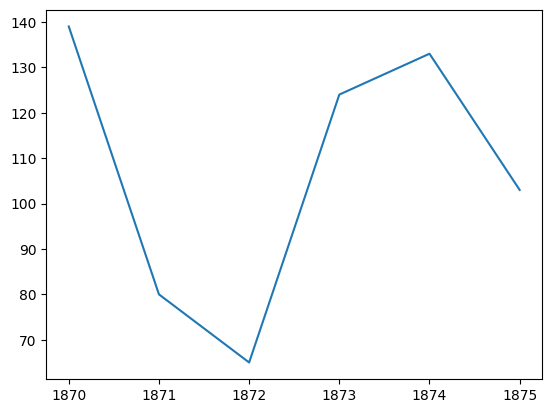

In [20]:
dagsbladet_paris.year.value_counts(sort = False).plot()

But this analysis has a flaw. Since the numbers shown above and in the graph is a mere count of articles within each year, we are not able to say that there are more articles comming from Paris in 1870 than in 1871 and 1872. Another exlpanation could be that the total amount of articles form the newspaper is high in 1870 and low in 1871 and 1872 thus affecting how many articles with the word "korrespondent" and "paris" in them. Such rise and fall in the total number could be caused by a change of publishing patterns of the newspaper e.g. if the newspaper was published every day in 1871 and then changed to only publishing every other day in 1871 and 1872. This would cause a halving of the total amount of articles and perhaps also affect the amount of articles with "korrespondent" and "paris" in them  



A solution to this would be to make more or less the same query as before, but without "korrespondent AND paris", thus getting all the articles from Dagsbladet between 1870 and 1875 and then doing the same as above and there by getting the total amount of articles from Dagsbladet pr. year. 

# 